<b>Trabalho de conclusão</b>

<b>REMOÇÃO DE REDUNDÂNCIAS E ERROS DE CLASSIFICAÇÃO NO CORPUS DE CONHECIMENTO DE UM CHATBOT</b>

<b>Integrantes:</b><br>
AUGUSTO DA SILVA CARVALHO<br>
BRUNO SERAFIM<br>
DOUGLAS LEMOS BRITO<br>
DOUGLAS MARQUES DE OLIVEIRA<br>
LUAN ANDRADE LOPES DA SILVA

<h1><font color='red' size>1. Leitura dos dados:</font></h1>

In [1]:
# importando parte das bibliotecas necessárias para o programa
import pandas as pd
import json
import re
import nltk
from nltk import tokenize
import gensim
from fuzzywuzzy import fuzz
from pymongo import MongoClient
import emoji

In [2]:
# lendo as notícias do dataset em csv
dados = pd.read_csv("dados/articles.csv")

In [3]:
dados.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [4]:
# salvando uma lista com os valores únicos da coluna categiria
categorias = dados.category.unique()

# exibindo a quantidade de notícias por categoria
print(f'{"Categoria":{30}} {"Notícias":>{10}}')
for categoria in categorias:
    quantidade = len(dados.loc[dados['category'] == categoria])
    print(f'{categoria:{30}} {quantidade:->{10}}')

Categoria                        Notícias
poder                          -----22022
ilustrada                      -----16345
mercado                        -----20970
mundo                          -----17130
esporte                        -----19730
tec                            ------2260
cotidiano                      -----16967
ambiente                       -------491
equilibrioesaude               ------1312
sobretudo                      ------1057
colunas                        -----21622
educacao                       ------2118
tv                             ------2142
banco-de-dados                 --------64
opiniao                        ------4525
ciencia                        ------1335
paineldoleitor                 ------4011
saopaulo                       ------3955
ilustrissima                   ------1411
seminariosfolha                -------379
turismo                        ------1903
empreendedorsocial             -------841
serafina                       ---

In [5]:
# selecionando as notícias da categoria comida
comida = dados.loc[dados['category'] == "comida"]
comida.head()

,title,text,date,category,subcategory,link
12786,"Morre o chef Alain Senderens, um dos precursor...","Morreu no ultimo domingo, 25, em sua casa em C...",2017-06-27,comida,NaN,http://www1.folha.uol.com.br/comida/2017/06/18...
22966,"Eleven Madison Park, de NY, é eleito o melhor ...",O nova-iorquino Eleven Madison Park foi nomead...,2017-05-04,comida,NaN,http://www1.folha.uol.com.br/comida/2017/04/18...
23456,Nada de arroz e feijão: saiba qual alimento un...,"Nem arroz, muito menos o feijão. Pergunte ao c...",2017-01-04,comida,NaN,http://www1.folha.uol.com.br/comida/2017/04/18...
25454,Como evitar comer carne estragada? Confira dicas,"Nesta sexta-feira (17), a Polícia Federal defl...",2017-03-17,comida,NaN,http://www1.folha.uol.com.br/comida/2017/03/18...
53641,Fazenda na Espanha produz foie gras de 'gansos...,Os espanhóis Eduardo Sousa e Diego Labourdette...,2016-08-22,comida,NaN,http://www1.folha.uol.com.br/comida/2016/08/18...


In [6]:
# salvando uma lista com as notícias da categoria comida
textos = comida['text'].dropna().tolist() + comida['title'].dropna().tolist()

In [7]:
# criando estrutura de dados para salvar os exemplos de treinamento do chatbot
dicionario_intencoes = {}

# lendo o arquivo JSON de todo o corpus de conhecimento do chatbot com ruídos inseridos
with open("dados/corpus2.json", encoding='utf-8') as json_file:
    dadados_json = json.load(json_file)
    # selecionamento as intenções do corpus de conhecimento
    intencoes = dadados_json.get("intents")
    for intencao in intencoes:
        nova_chave = {intencao.get("intent") : [exp.get("text") for exp in intencao.get("examples")]}
        # anexando os exemplos e cada uma das intenções à estrutura de dados
        dicionario_intencoes.update(nova_chave)

# anexando os exemplos à lista de notícias da categoria comida
for x in dicionario_intencoes:
    textos += dicionario_intencoes.get(x)
    
print(f"Quantidade de documentos no dataset: {len(textos)}")

Quantidade de documentos no dataset: 1939


In [8]:
# iniciando conexão com o banco de dados noSQL MongoDB
client = MongoClient('localhost', 27017)

# instanciando a coleção de tweets sobre comida
db = client.twitterdb3
col = db.tweets

In [9]:
# criando um dataset com dados retornados da coleção
tweets = [tweet["text"] for tweet in col.find()]

<h1><font color='red' size>2. Normalização do texto:</font></h1>

In [10]:
tweets_limpos = []

# compilando regex para identificar nomes de usuário e urls nos tweets
nome_usuario_pattern = re.compile('\@\w+')
url_pattern = re.compile('\bhttps?:\/\/.*\b')
risada_pattern = re.compile('\bk+\b')

# instanciando objeto com a lista de emojis
emojis = emoji.UNICODE_EMOJI

# para cada tweet
for tweet in tweets:
    # removendo os termos 'rt', nome de usuário, urls e outros padrões comuns no texto do tweet 
    texto_tweet = tweet.lower()
    texto_tweet = texto_tweet.replace('rt','')
    texto_tweet = re.sub(nome_usuario_pattern, "", texto_tweet)
    texto_tweet = re.sub(url_pattern, "", texto_tweet)
    texto_tweet = re.sub(risada_pattern, "", texto_tweet)
    
    # removendo os emojis do texto do tweet
    letras_texto = [str for str in texto_tweet]
    lista_emojis = [c for c in letras_texto if c in emojis]
    texto_tweet = ' '.join([str for str in texto_tweet.split() if not any(i in str for i in lista_emojis)])
    
    # anexando o tweet limpo à lista
    tweets_limpos.append(texto_tweet)

print(f"Quantidade total de tweets: {len(tweets_limpos)}")

# removendo tweets duplicados da lista de tweets limpos
tweets_limpos = list(dict.fromkeys(tweets_limpos))
print(f"Quantidade de tweets únicos: {len(tweets_limpos)}")

# anexando os tweets limpos ao dataset
textos += tweets_limpos
print(f"Quantidade de frases no dataset: {len(textos)}")

Quantidade total de tweets: 1100132
Quantidade de tweets únicos: 616102
Quantidade de frases no dataset: 618041


In [11]:
# instanciando os objetos da biblíoteca NLTK com o tokenizador e a lista de stopwords
sent_tokenizer = nltk.data.load('tokenizers/punkt/portuguese.pickle')
stopwords = nltk.corpus.stopwords.words('portuguese')

# adicionando outras palavras à lista de stopswords
stopwords += ["tá", "to", "tô", "tu", "ta", "ti", "pra", "pro", "po", "pô", "pá", "pa", "ei", "ai", "aí"]

# compilando regex para identificar caracteres que não sejam palavras
regex = re.compile('\W')

# declarando lista que guardará as senteças tokenizadas dos textos
sentencas_tokenizadas = []

## descomentar para fazer uma demo com um dataset menor
#for x in range(200):
#    sentencas = sent_tokenizer.tokenize(noticias[x])

# para texto no dataset
for texto in textos:
    
    # dividindo o texto em sentenças
    sentencas = sent_tokenizer.tokenize(texto)
    
    # pra cada sentença no texto
    for sentenca in sentencas:
        # tokenizando as palavras da sentença
        sentenca_tokenizada = tokenize.word_tokenize(sentenca, language='portuguese')
        
        # declarando a variável que guardará a lista de palavras tokenizadas sem stopwords da sentença
        sentenca_tokenizada_limpa = []
        
        # pra cada palavra na lista de tokens da sentença
        for token in sentenca_tokenizada:
            if token.lower() not in stopwords and not regex.match(token):
                # salvando o token na lista de palavras limpa de stopwords, pontuações e sufixos
                palavra = token.lower()
                if len(palavra) < 2: continue
                sentenca_tokenizada_limpa.append(palavra)
        # adicionando a sentença tokenizada e sem stopwords na lista de sentenças
        sentencas_tokenizadas.append(sentenca_tokenizada_limpa)

<h1><font color='red' size>3. Treinamento do modelo:</font></h1>

In [12]:
# treinando e salvando o modelo

## descomentar modelo para demonstração
#modelo = gensim.models.Word2Vec(sentencas_tokenizadas)

modelo = gensim.models.Word2Vec(sentencas_tokenizadas, min_count = 3, size = 900,
                                workers = 9, window = 5, iter = 40)
modelo.save('comida.embedding')

# imprimindo o tamanho do vocabulário do modelo treinado
print(f"Quantidade de termos no vocabulário treinado pelo modelo: {len(modelo.wv.vocab)}")

Quantidade de termos no vocabulário treinado pelo modelo: 52686


In [13]:
# comparando duas palavras utilizando word embeddings

p1 = 'feijão'
p2 = 'feijoada'
print(p1,p2)
modelo.wv.similarity(p1,p2)

feijão feijoada


0.26718643

In [14]:
# buscando os termos mais próximos da palavra "floresta"

modelo.wv.most_similar(positive=['ingredientes'], topn = 10)

[('métodos', 0.4453939199447632),
 ('usados', 0.4360498785972595),
 ('preparos', 0.43363621830940247),
 ('produtos', 0.43139922618865967),
 ('molhos', 0.41581296920776367),
 ('técnicas', 0.41462111473083496),
 ('utensílios', 0.4037242829799652),
 ('itens', 0.4014296531677246),
 ('fornecedores', 0.40126660466194153),
 ('locais', 0.40051499009132385)]

In [15]:
# buscando os termos mais próximos da palavra "restaurante"

modelo.wv.most_similar(positive=['restaurante'], topn = 10)

[('churrascaria', 0.40574419498443604),
 ('pizzaria', 0.4039906859397888),
 ('comida', 0.3960467278957367),
 ('restaurantes', 0.3785538673400879),
 ('mandarin', 0.3748994469642639),
 ('ifood', 0.36372631788253784),
 ('padaria', 0.3527158498764038),
 ('jantar', 0.33752381801605225),
 ('churrasco', 0.3061748147010803),
 ('garçom', 0.3053820729255676)]

In [16]:
# buscando vetores parecidos com a resultante da subtração dos vetores da palavra feijão dos vetores
# da palavra feijoada, somada aos vetores da palavra peixe

modelo.wv.most_similar(positive=['peixe', 'feijoada'], negative=['feijão'], topn = 5)

[('peixada', 0.25902122259140015),
 ('peixe..', 0.23666958510875702),
 ('peroá', 0.23275479674339294),
 ('maraca', 0.2263709306716919),
 ('churrasco', 0.2131415158510208)]

In [17]:
from scipy import spatial
import numpy as np

# função que recebe uma frase e retorna o vetor de média das dimensões das palavras da frase
def vetor_frase(frase):
    # tokenizando e limpando a frase de stopwords e outras palavras que não constem no vocabulário do modelo
    vetor_frase = [palavra for palavra in tokenize.word_tokenize(frase, language='portuguese')
                   if palavra not in stopwords and palavra in modelo.wv.vocab]
    # retorna um vetor preenchido com zeros caso a frase tenha sido descartada durante a limpeza
    if len(vetor_frase) < 2:
        return np.zeros(len(modelo.wv.__getitem__('comida')))
    # retornando o vetor com a média
    return np.mean(modelo.wv.__getitem__(vetor_frase), axis=0)

# função que recebe duas frases e retorna a distância semântica entre as duas frases
def similaridade_cossenos(frase1, frase2):
    # buscando os vetores das frases 1 e 2
    vetor1 = vetor_frase(frase1)
    vetor2 = vetor_frase(frase2)
    sim_cossenos = 1 - spatial.distance.cosine(vetor1, vetor2)
    # retornando a distância entre os cossenos dos vetores da frase 1 e 2
    # caso o valor da distância seja nulo, retorna 0
    # caso o valor da distância seja infinito, retorn 100
    # caso o valor da distância não seja nulo e não seja infinito, retorna a distância multiplicada por 100
    if np.isnan(sim_cossenos): return 0
    elif np.isinf(sim_cossenos): return 100
    else: return sim_cossenos*100

In [18]:
# comparando a semelhança entre duas frases
s1 = 'gostaria de comer uma feijoada'
s2 = 'gostaria de comer uma dobradinha'
print('semelhança = %.3f' % similaridade_cossenos(s1, s2))

distância = 79.438


In [19]:
s1 = 'gostaria de comer uma feijoada'
s2 = 'o chefe esqueceu de usar sal no arroz'
print('semelhança = %.3f' % similaridade_cossenos(s1, s2))

distância = 14.914


In [20]:
s1 = 'quer ir tomar uma cachaça no bar?'
s2 = 'bora beber uma cerveja no boteco?'
print('semelhança = %.3f' % similaridade_cossenos(s1, s2))

distância = 66.811


<h1><font color='red' size>4. Comparando os exemplos do corpus:</font></h1>

In [24]:
# inicializando contadores, listas e dicionários utilizados nas comparações
contador_comparacoes = 0
comparacoes = {}
medias = []

# para cada intenção x do corpus
for intencao1 in dicionario_intencoes:
    # para cada intenção y do corpus
    for intencao2 in dicionario_intencoes:
        # para cada exemplo da intenção x
        for exemplo1 in dicionario_intencoes.get(intencao1):
            acumulador_media1 = 0
            acumulador_media2 = 0
            contador_media1 = 0
            contador_media2 = 0
            
            # para cada exemplo da intenção y
            for exemplo2 in dicionario_intencoes.get(intencao2):
                
                # comparando a semelhança entre dois exemplos
                frase1 = exemplo1.lower()
                frase2 = exemplo2.lower()
                
                # calculando a distância semântica
                distancia_semantica = similaridade_cossenos(frase1, frase2)
                
                # calculando a distância de edição
                distancia_edicao = 100 - (fuzz.partial_ratio(frase1, frase2) + fuzz.token_sort_ratio(frase1, frase2))/2
                
                # acumulando resultado do cálculo da distância semântica para a média
                acumulador_media1 += distancia_semantica
                contador_media1 += 1
                
                # acumulando resultado do cálculo da distância de edição para a média
                acumulador_media2 += distancia_edicao
                contador_media2 += 1
                
                contador_comparacoes += 1
                
                # adicionando dados calculados durante a iteração na lista de resultados
                nova_comparacao = {contador_comparacoes : [intencao1, intencao2, exemplo1, exemplo2, distancia_semantica, distancia_edicao]}
                comparacoes.update(nova_comparacao)
            
            # calculando e salvando as médias calculadas durante a iteração
            media1 = acumulador_media1/contador_media1
            media2 = acumulador_media2/contador_media2
            medias.append([intencao1, exemplo1, intencao2, media1, media2])
            
print(f'\n\nForam feitas {contador_comparacoes} comparações no total!')

c:\users\imopts\appdata\local\programs\python\python37\lib\site-packages\scipy\spatial\distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)




Foram feitas 80089 comparações no total!


<h1><font color='red' size>5. Relatório:</font></h1>

In [25]:
# criando os dataframes para o relatório

lista_comparacoes = pd.DataFrame(comparacoes,
                                 index=['intenção 1', 'intenção 2', 'exemplo 1', 'exemplo 2', 'semelhança semântica',
                                        'distância de edição'], columns= None).T

lista_medias = pd.DataFrame(medias,columns=['intencao', 'exemplo', 'intenção 2', 'semelhança semântica',
                                            'distância de edição'])

In [26]:
# salvando a lista de comparações no formato xlsx
lista_comparacoes.to_excel("relatórios/lista_comparacoes.xlsx", engine="openpyxl")
lista_comparacoes.head()

,intenção 1,intenção 2,exemplo 1,exemplo 2,semelhança semântica,distância de edição
1,consultar_preco,consultar_preco,Qual o preço da coca cola?,Qual o preço da coca cola?,100,0
2,consultar_preco,consultar_preco,Qual o preço da coca cola?,Quanto custa a taxa de entrega?,18.0375,57
3,consultar_preco,consultar_preco,Qual o preço da coca cola?,Quanto custa a cerveja?,19.8051,57
4,consultar_preco,consultar_preco,Qual o preço da coca cola?,Qual o preço da batara frita?,57.4683,32
5,consultar_preco,consultar_preco,Qual o preço da coca cola?,Por quanto sai o lanche?,15.8862,53.5


In [27]:
# calculando a semelhança semântica e distância de edição médias de todos os exemplos do corpus2
md_semelhanca_semantica = lista_comparacoes['semelhança semântica'].mean()
md_distancia_edicao = lista_comparacoes['distância de edição'].mean()

print(f"Média de semelhança semântica de todos os exemplos: {round(md_semelhanca_semantica, 4)}")
print(f"Média de distância de edição de todos os exemplos: {round(md_distancia_edicao, 4)}")

Média de semelhança semântica de todos os exemplos: 9.0073
Média de distância de edição de todos os exemplos: 61.8898


In [28]:
# calculando o desvio padrão da semelhança semântica e distância de edição de todos os exemplos do corpus2
dp_semelhanca_semantica = lista_comparacoes['semelhança semântica'].std()
dp_distancia_edicao = lista_comparacoes['distância de edição'].std()

print(f"Desvio padrão da semelhança semântica de todos os exemplos: {round(dp_semelhanca_semantica, 4)}")
print(f"Desvio padrão da distância de edição de todos os exemplos: {round(dp_distancia_edicao, 4)}")

Desvio padrão da semelhança semântica de todos os exemplos: 15.0974
Desvio padrão da distância de edição de todos os exemplos: 8.9583


In [29]:
# iniciando as listas das médias por intenção
medias_semanticas = []
medias_dist_edicao = []

# para cada intenção no relatório
for intencao in lista_comparacoes['intenção 1'].unique():
    # buscando todas as comparações cujo o exemplo1 pertence a intenção em questão
    camparacoes_int = lista_comparacoes.loc[lista_comparacoes['intenção 1'] == intencao]
    
    # salvando a semelhança semântica e distância de edição médias das comparações
    # filtradas na busca anterior
    temp_media_semantica = camparacoes_int['semelhança semântica'].mean()
    temp_media_dist_edicao = camparacoes_int['distância de edição'].mean()
    medias_semanticas += [(intencao, temp_media_semantica)]
    medias_dist_edicao += [(intencao, temp_media_dist_edicao)]

# convertendo a lista de tuplas para o formato DataFrame
medias_semanticas = pd.DataFrame(medias_semanticas, columns =['intenção', 'semelhança semântica média'])
medias_dist_edicao = pd.DataFrame(medias_dist_edicao, columns =['intenção', 'distância de edição média'])

In [30]:
# importando a função de normalização da biblioteca sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# normalizando os dados antes de exibir as médias no gráfico
norm_medias_semanticas = medias_semanticas
norm_medias_semanticas['semelhança semântica média'] = scaler.fit_transform(
    norm_medias_semanticas['semelhança semântica média'].values.reshape(-1,1))

norm_medias_dist_edicao = medias_dist_edicao
norm_medias_dist_edicao['distância de edição média'] = scaler.fit_transform(
    norm_medias_dist_edicao['distância de edição média'].values.reshape(-1,1))

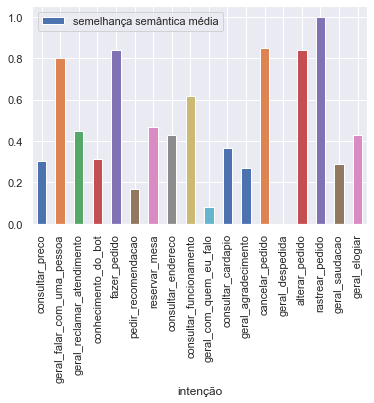

In [68]:
# exibindo o gráfico com a semelhança semântica média entre os exemplos das intenções do corpus2 
medias_semanticas.plot.bar(x='intenção',y='semelhança semântica média')

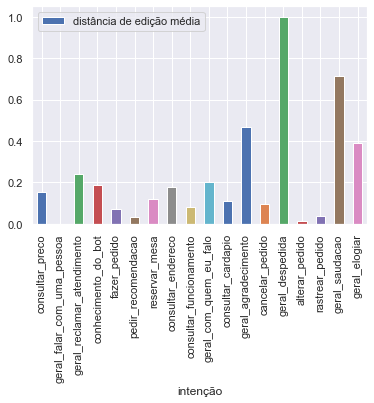

In [69]:
# exibindo o gráfico com a distância de edição média entre os exemplos das intenções do corpus2
medias_dist_edicao.plot.bar(x='intenção',y='distância de edição média')

In [33]:
# salvando a lista com as médias das comparações no formato xlsx
lista_medias.to_excel('relatórios/lista_medias.xlsx', engine="openpyxl")
lista_medias.head()

,intencao,exemplo,intenção 2,semelhança semântica,distância de edição
0,consultar_preco,Qual o preço da coca cola?,consultar_preco,23.815719,52.857143
1,consultar_preco,Quanto custa a taxa de entrega?,consultar_preco,33.183765,49.464286
2,consultar_preco,Quanto custa a cerveja?,consultar_preco,29.173827,51.500000
3,consultar_preco,Qual o preço da batara frita?,consultar_preco,23.957315,53.785714
4,consultar_preco,Por quanto sai o lanche?,consultar_preco,26.927064,51.678571


<h1><font color='red' size>6. Aferindo os resultados:</font></h1>

In [61]:
from sklearn.metrics import precision_recall_fscore_support

# a função recebe uma lista com as classes verdadeiras e as classes preditas dos exemplos testados
# o retorno da função é uma string com os valores de precisão, revocação e o f1-score
def imprime_metricas(intencoes_verdadeiras, intencoes_preditas):
    resultados = precision_recall_fscore_support(intencoes_verdadeiras, 
                                                 intencoes_preditas, average='macro')
    return f"Precisão: {resultados[0]:.4f}\nRevocação: {resultados[1]:.4f}\nF1-score: {resultados[2]:.4f}"

In [62]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sb
import matplotlib.pyplot as pyplt
import matplotlib.cm as mtzcf
%matplotlib inline

# a função recebe uma lista com as classes verdadeiras e as classes preditas dos exemplos testados
def exibir_matriz_relatorio(int_verdadeiras, int_preditas, nome_corpus):
    
    # adicionando uma classe para os casos onde a heurística de teste foi utilizada
    # salvando o nomes das classes em uma lista
    classes_verdadeiras = list(int_verdadeiras.unique()) + [" confianca_baixa"]
    classes_preditas = list(int_preditas.unique())
    
    # removendo a classe para os casos onde a herística de teste não precisou ser usada
    if " confianca_baixa" not in classes_preditas:
        classes_verdadeiras.remove(" confianca_baixa")
    
    # ordenando alfabéticamente as litas com os nomes das classes
    classes_verdadeiras.sort()
    classes_preditas.sort()
    
    # criando a matriz de confusão
    matriz_confusao = confusion_matrix(int_verdadeiras, int_preditas)
    
    # transpondo a matriz de confusão
    matriz_confusao_df = pd.DataFrame(matriz_confusao, index = classes_preditas,
                                      columns = classes_verdadeiras)
    
    # configurando o tamanho de exibição da matriz de confusão
    pyplt.figure(figsize = (15,10.5))
    pyplt.clf()
    sb.set(font_scale=1.4)
    
    # centralizando os números exibidos no topo e fundo da matriz
    ax = sb.heatmap(matriz_confusao_df, annot=True, annot_kws={"size": 16})
    fundo, topo = ax.get_ylim()
    ax.set_ylim(fundo + 0.5, topo - 0.5)
    
    # definindo título, nome do eixo x e nome do eixo y
    titulo_relatorio = f'Testes do {nome_corpus}\n\n{imprime_metricas(int_verdadeiras, int_preditas)}'
    pyplt.title(f'{titulo_relatorio}\n\nAcurácia: {round(accuracy_score(int_verdadeiras, int_preditas)*100, 2)}%')
    pyplt.ylabel('Intenção verdadeira')
    pyplt.xlabel('Intenção predita')
    
    # exibindo a matriz de confusão na tela
    sb.set()
    pyplt.show()

In [63]:
# a função recebe como um caminho para buscar um arquivo com os resultados dos testes
# a função retorna um dataframe tratado
def ler_arquivo_teste(caminho_arquivo):
    # lendo o arquivo csv com os resultados dos testes 
    testes_corpus = pd.read_csv(caminho_arquivo)
    
    # localizando os testes com confiança menor que 40% e mudando a classe para 'confianca_baixa'
    testes_corpus.loc[corpus['confianca'] < 0.4, 'classe_predita'] = ' confianca_baixa'
    
    # retorna o dataframe com a herística testes aplicada
    return testes_corpus

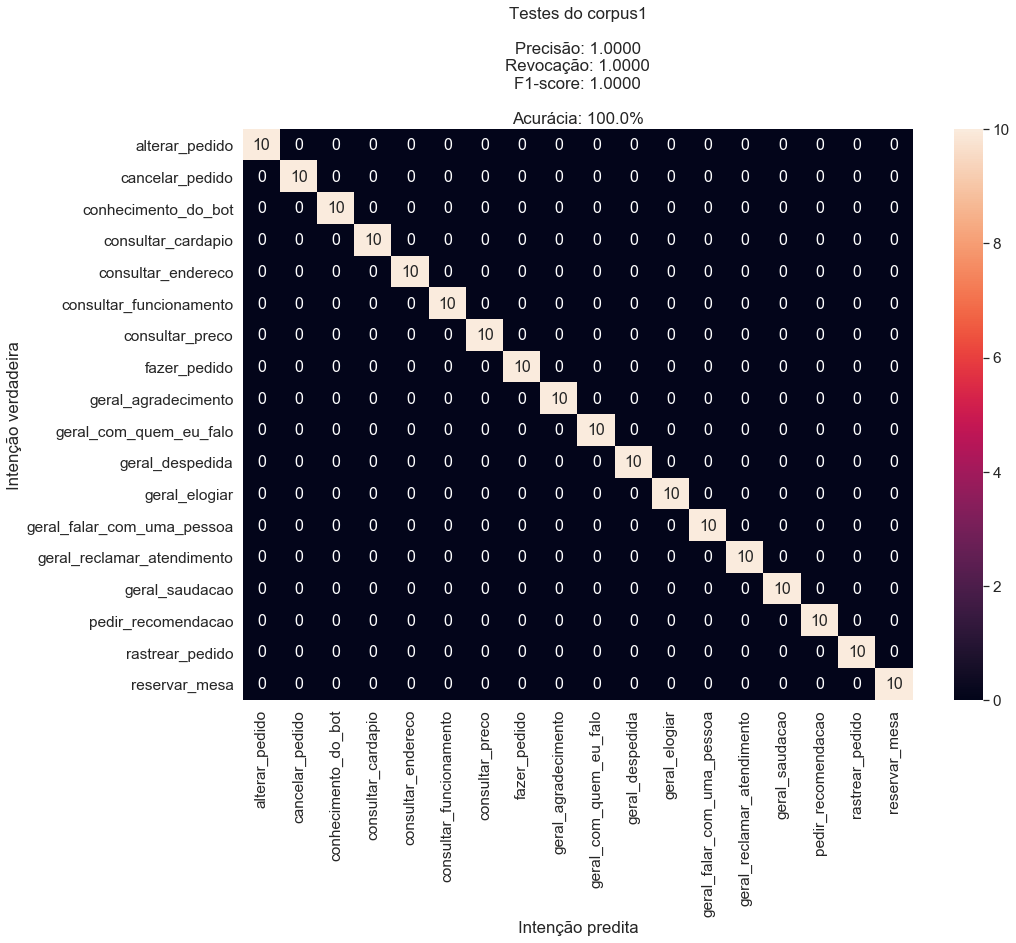

In [64]:
# aferindo os resultados do corpus original
teste_corpus1 = ler_arquivo_teste("dados/testes_corpus1.csv")

exibir_matriz_relatorio(teste_corpus1['classe_verdadeira'],
                       teste_corpus1['classe_predita'], 'corpus1')

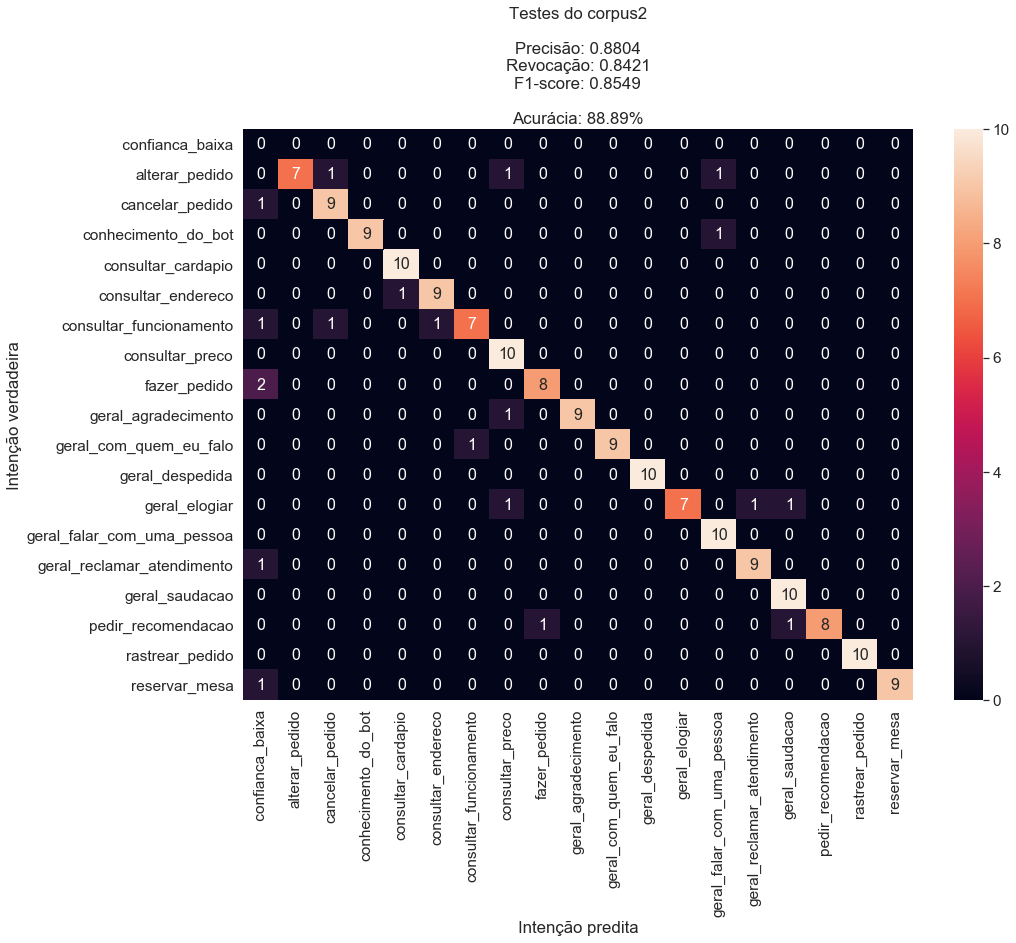

In [65]:
# aferindo os resultados do corpus com ruídos inseridos
teste_corpus2 = ler_arquivo_teste("dados/testes_corpus2.csv")

exibir_matriz_relatorio(teste_corpus2['classe_verdadeira'],
                       teste_corpus2['classe_predita'], 'corpus2')

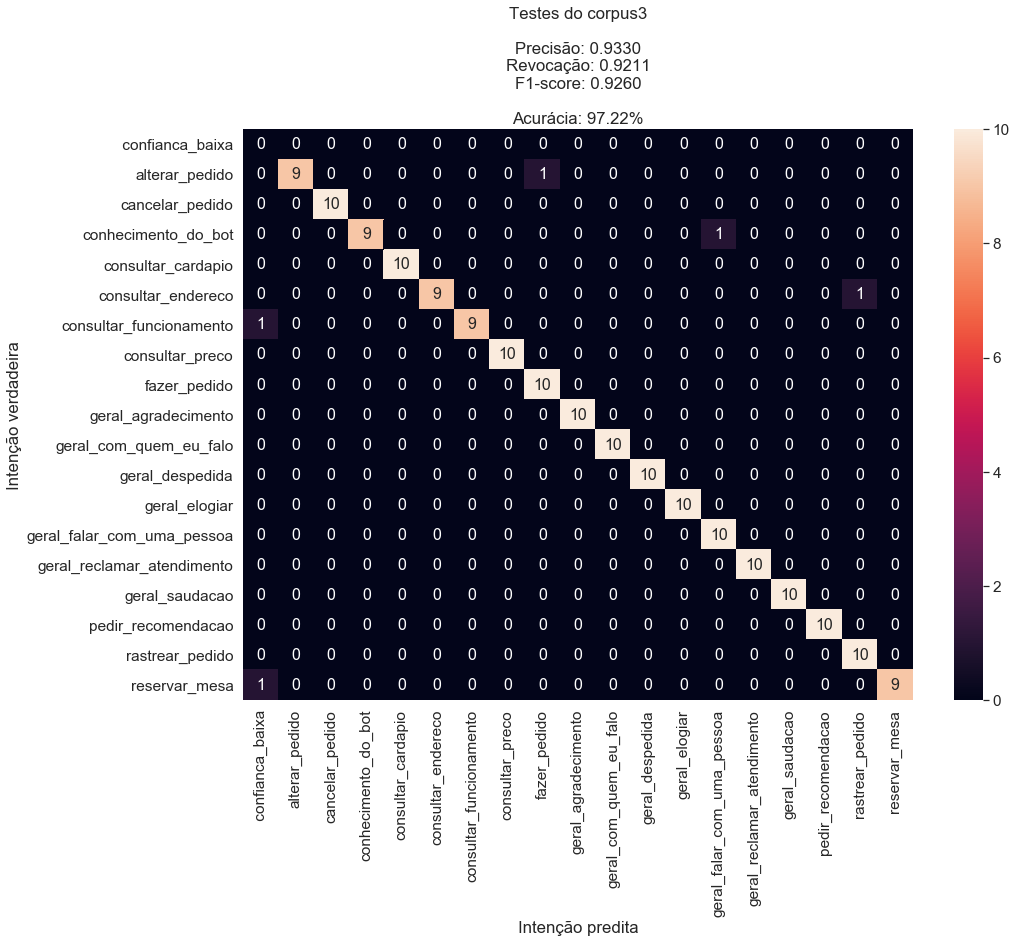

In [66]:
# aferindo os resultados do corpus com ruídos parcialmente excluidos
teste_corpus3 = ler_arquivo_teste("dados/testes_corpus3.csv")

exibir_matriz_relatorio(teste_corpus3['classe_verdadeira'],
                       teste_corpus3['classe_predita'], 'corpus3')